# Lesson 6: Clipping Raster Images with Python

## Sections:

1. [Loading Shapefile and Raster Data](#step_1)


- [Suggested Readings](#readings)
- [References](#references)

# <a id='step_1'></a>

## Step 1: Loading Shapefile and Raster Data

In [134]:
from IPython.display import Image
import shapefile as sf
from osgeo import gdal, gdalnumeric, ogr, osr
import pandas as pd
import numpy as np

In [71]:
raster = "Data/AERONET_Fort_McMurray.2016136.terra.1km.tif"
shp = "Data/Alberta/Alberta.shp"

In [133]:
#
# ---------------------------------------------------------------------------
# Open and transform the raster file into a numpy array
#
# The array has length 3, which is each band: in this case RGB
# Each band has a length of 720, since there are 720 rows in the pixel count
# Each row has 960 entries, since the image is 960 pixels wide. 
#
# (This is why I have opened the 1km image, rather than the 250m image - less pixels to deal with ;-)) 
#----------------------------------------------------------------------------
#

raster_array = gdalnumeric.LoadFile(raster)

print(raster_array.shape)

print("\n Band 1 values (Red): \n {}".format(raster_array[0]))
print("\n Band 2 values (Green): \n {}".format(raster_array[1]))
print("\n Band 3 values (Blue): \n {}".format(raster_array[2]))


(3, 720, 960)

 Band 1 values (Red): 
 [[ 49  47  41 ...,  29  52  36]
 [ 52  47  40 ...,  52  49  41]
 [ 52  46  40 ...,  49  27  49]
 ..., 
 [ 58  45 153 ...,  97 241 200]
 [195  62  36 ...,  83 114 124]
 [246 190 120 ...,  93  95  48]]

 Band 2 values (Green): 
 [[ 52  50  44 ...,  22  45  29]
 [ 54  49  42 ...,  45  42  34]
 [ 54  48  42 ...,  45  20  42]
 ..., 
 [ 60  47 153 ...,  98 242 199]
 [197  62  36 ...,  84 115 125]
 [248 190 120 ...,  94  96  49]]

 Band 3 values (Blue): 
 [[ 45  43  37 ...,  12  35  19]
 [ 49  44  37 ...,  35  32  24]
 [ 49  43  37 ...,  34  10  32]
 ..., 
 [ 59  46 151 ...,  93 237 197]
 [196  62  34 ...,  79 110 120]
 [247 188 118 ...,  89  91  44]]


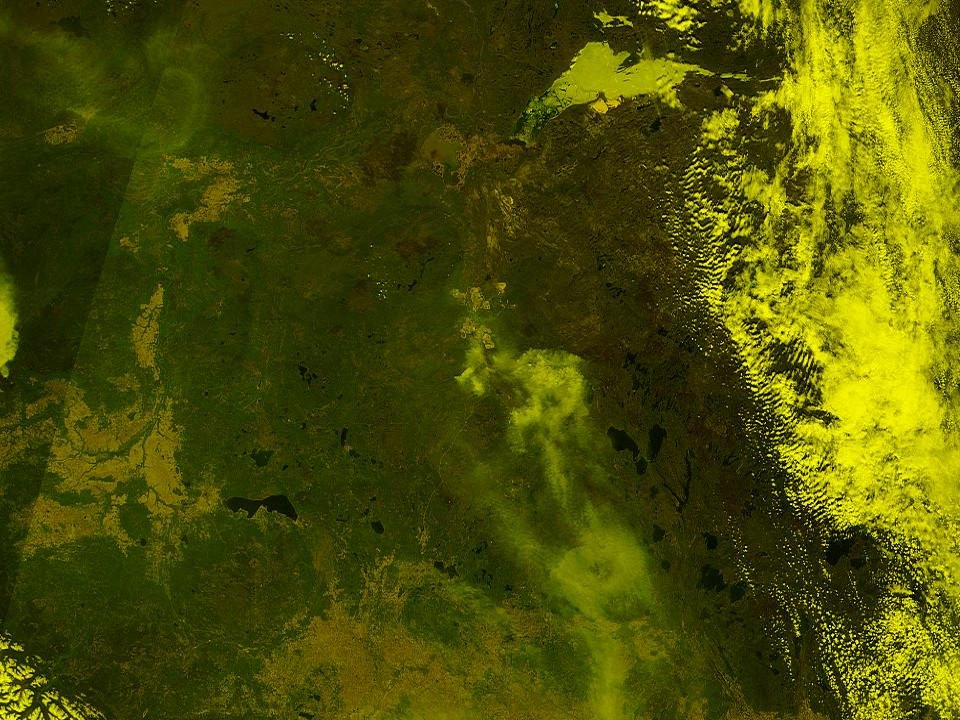

In [113]:
#
# --------------------------------------------------------------------------------------
# To see what happens if you mask a band when you re-write:
#
# (note: you still require 3 bands for jpg format, so we set the blue band to zero values)
# ---------------------------------------------------------------------------------------
#


blue_band = np.zeros_like(raster_array[2])
test_array = np.array([raster_array[0], raster_array[1], blue_band])

gdalnumeric.SaveArray(test_array, "Images/RG_only_image.jpg", format="JPEG")

Image(filename='Images/RG_only_image.jpg')

In [144]:
# Also open the raster layer as a gdal Image object (Dataset)
raster_image = gdal.Open(raster)

# Fetch the affine transformation coefficients. (google: gdal.Dataset.GetGeoTransform)
raster_geo = raster_image.GetGeoTransform()

print(raster_image.GetDescription(), "\n \n", raster_image, "\n \n", raster_geo)

#
# See help(gdal.Dataset) for more methods, info, etc
#

Data/AERONET_Fort_McMurray.2016136.terra.1km.tif 
 
 <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fbc350ee750> > 
 
 (-120.1074, 0.017986411845195546, 0.0, 59.9881, 0.0, -0.008993205922597801)


In [122]:
# Create an org.DataSource object by opening the shapefile, extract the layer that we want:
# see http://gdal.org/python/osgeo.ogr.Layer-class.html
shape_file = ogr.Open(shp)
shape_layer = shape_file.GetLayer()
print(shape_layer.GetName())

#
# -----------------------------------------------------------------------------
# Other methods to help find the layer you need if there is more than one:
#
# ogr.DataSource.GetLayerByIndex(i)
# ogr.DataSource.GetLayerByName(char)
#-------------------------------------------------------------------------------
#

# Extract the coordinate points that describe the boundary of Alberta:
poly = shape_layer.GetNextFeature()
geom = poly.GetGeometryRef()
pts = geom.GetGeometryRef(0)
print("Points in boundary: {}".format(pts.GetPointCount()))

#
# ---------------------------------------------------------------------------------------------------------------------
# Another way to access points, from lesson 5:
#
# alberta = sf.Reader("Data/Alberta/Alberta")
# points = alberta.shape(0).points
# len(points)
#-----------------------------------------------------------------------------------------------------------------------
#

# Get the x and y min and max values
X_min, Y_min, X_max, Y_max = shape_layer.GetExtent()
print("Bounding box: {}".format(shape_layer.GetExtent()))

#
#----------------------------------------------------------
# same as:
# bb = albert.shape(0).bbox
# X_min = bb[0]
# Y_min = bb[1]
# X_max = bb[2]
# Y_max = bb[3]
# ---------------------------------------------------------
#

Alberta
Points in boundary: 17996
Bounding box: (-120.00029747299993, -109.9998580489999, 48.99999999400006, 60.00007326000008)


In [156]:
#
#-------------------------------------------------------------------------------------------
# J Lawheads function to convert geo-coordinate to pixel placement
# see: http://geospatialpython.com/2011/02/clip-raster-using-shapefile.html
#
# Similar to python_GIS_scripts/simpleGIS.py
#-------------------------------------------------------------------------------------------
#

def world2Pixel(geoMatrix, x, y):
  """
  Uses a gdal geomatrix (gdal.GetGeoTransform()) to calculate
  the pixel location of a geospatial coordinate 
  """
  ulX = geoMatrix[0]
  ulY = geoMatrix[3]
  xDist = geoMatrix[1]
  yDist = geoMatrix[5]
  rtnX = geoMatrix[2]
  rtnY = geoMatrix[4]
  pixel = int((x - ulX) / xDist)
  line = int((ulY - y) / yDist)
  return (pixel, line) 


# Then we pass the raster image and the known bounding box values from the shape_layer to turn the image pixels into 
# appropriate pixel locations:
upper_left_x, upper_left_y = world2Pixel(raster_geo, X_min, Y_max)
lower_right_x, lower_right_y = world2Pixel(raster_geo, X_max, Y_min)


# Calculate the pixel size of the new image
pxWidth = int(lower_right_x - upper_left_x)
pxHeight = int(lower_right_y - upper_left_y)


#
# So now we know what size the new image is going to be, by having found the size and shape of the 
# shapefile layer in terms of pixels. 
#


# Take the raster_array and clip it to the same pixel based bounding box as the shapefile layer
clipped_raster = raster_array[:, upper_left_y:lower_right_y, upper_left_x:lower_right_x]

# might not be needed - already passsed to world2Pixel so already has min x and max y values
# Create a new geomatrix for the image
#raster_geo = list(raster_geo)
#raster_geo[0] = X_min
#raster_geo[3] = Y_max


# Create a mask image from the outline of Alberta on a blank 8-bit black & white raster
# Credit: J Lawhead; http://geospatialpython.com/2011/02/clip-raster-using-shapefile.html
points = []
pixels = []
for p in range(pts.GetPointCount()):
  points.append((pts.GetX(p), pts.GetY(p)))
for p in points:
  pixels.append(world2Pixel(raster_geo, p[0], p[1]))
rasterPoly = Image.new("L", (pxWidth, pxHeight), 1)
rasterize = ImageDraw.Draw(rasterPoly)
rasterize.polygon(pixels, 0)
mask = imageToArray(rasterPoly)   

AttributeError: type object 'Image' has no attribute 'new'

Help on function GetGeoTransform in module osgeo.gdal:

GetGeoTransform(self, *args, **kwargs)
    GetGeoTransform(self, int can_return_null = None)



# <a id='readings'></a>

## Suggested Readings

# <a id='References'></a>

## References

- Lawhead, J; *"Clip a Raster Using a Shapefile"*, <a href='http://geospatialpython.com/2011/02/clip-raster-using-shapefile.html'>GeospatialPython.com</a>. 2011.